In [21]:
#!pip install utils
#!pip install livelossplot
!pip install keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


In [2]:
for expression in os.listdir('/Users/anjalisingh/Documents/Dataset_FER/train/'):
    print(str(len(os.listdir('/Users/anjalisingh/Documents/Dataset_FER/train/'+expression))) + " " + expression + " images")

4593 fear images
3586 surprise images
5483 sadness images
5572 neutral images
8110 happiness images
4462 anger images
493 disgust images


We will try to minimise loss of the Neural Network using Mini batch gradient descent(fixed number of training example used for one step of Gradient Descent). First calculate Gradient of Mini batches and use these mini batches to find mean Gradient Descent. Feed gradient descent to Neural Network and update the weights and repeat until u come to a local optima and converge.

In [5]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("/Users/anjalisingh/Documents/Dataset_FER/train/",
                                                   target_size=(img_size, img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True
                                                   )
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory('/Users/anjalisingh/Documents/Dataset_FER/test/',
                                                        target_size=(img_size, img_size),
                                                        color_mode='grayscale',
                                                        batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=True
                                                        )

Found 32298 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Link to the research Paper:

https://arxiv.org/pdf/1307.0414.pdf

In [8]:
model = Sequential()

# 1 - conv
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2-conv layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - conv
model.add(Conv2D(512, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4-conv layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 128)      

## Train and Evaluate Model

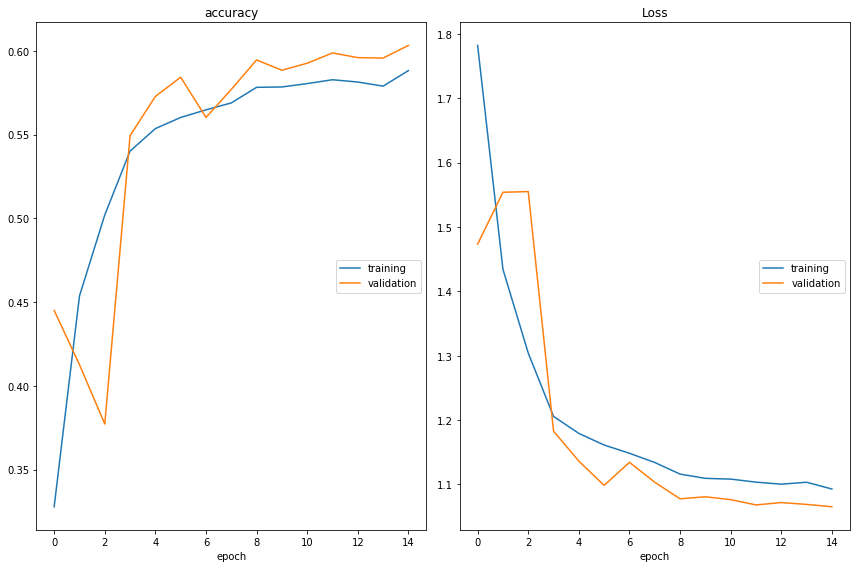

accuracy
	training         	 (min:    0.328, max:    0.588, cur:    0.588)
	validation       	 (min:    0.377, max:    0.603, cur:    0.603)
Loss
	training         	 (min:    1.093, max:    1.782, cur:    1.093)
	validation       	 (min:    1.065, max:    1.555, cur:    1.065)

Epoch 00015: saving model to model_weights.h5
504/504 [==============================] - 344s 682ms/step - loss: 1.0929 - accuracy: 0.5882 - val_loss: 1.0653 - val_accuracy: 0.6032


In [23]:
epochs =15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
callbacks = [ PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
            x=train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks
)



To save rest of our architecture we are gonna use Json String

In [24]:
model_json = model.to_json()
with open("model_FER.json", 'w') as json_file:
    json_file.write(model_json)